# Importing libraries

In [2]:
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import treebank
nltk.download('treebank')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Prepare 

## Read each line in train/test file and split word and its part-of-speech by '/' seperator

In [3]:
def readData(filePath):
    with open(filePath, 'r', encoding='utf8') as f:
        file = f.read().splitlines()
    data = [[] for _ in range(len(file))]
    for idx, i in enumerate(file):
        sentence = i[4:]
        a = sentence.split()
        data[idx].append(('', '<s>'))
        for j in a:
            tmp = (j.rsplit('/',1))
            data[idx].append((tmp[0], tmp[1]))
    return data


In [4]:
trainData = readData('/content/drive/MyDrive/CS221/data/rawData/train50.txt')
testData = readData('/content/drive/MyDrive/CS221/data/rawData/test50.txt')

In [5]:
def func(data):
    corpusData = []
    posData = []
    for sentence in data:
        tempCorpus = []
        tempPos = []
        for pair in sentence:
            if pair[0] != '':
                tempCorpus.append(pair[0])
                tempPos.append(pair[1])
        corpusData.append(tempCorpus)
        posData.append(tempPos)
    return (corpusData,posData)


In [6]:
trainCorpusData, trainPosData = func(trainData)
testCorpusData, testPosData = func(testData)

In [7]:
trainPosDataWithS = list()
for i in trainPosData:
    i = ['<s>'] + i
    trainPosDataWithS.append(i)

## Create list of train and test tagged words

In [8]:
trainTagged = [tup for sent in trainData for tup in sent]

## Check how many unique tags are present in training data

In [9]:
tags = list({tag for word,tag in trainTagged})
tags.remove('<s>')
fullTags = tags.copy()
fullTags.append('<s>')
unique_tags = len(fullTags)

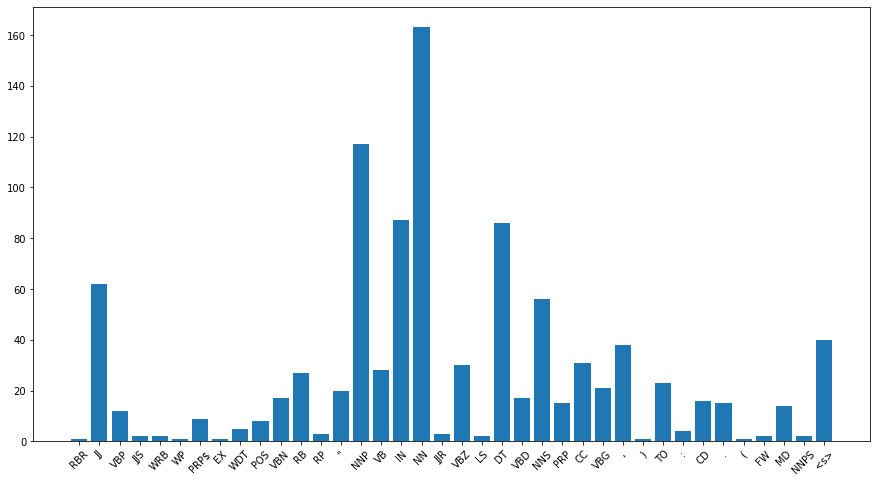

In [10]:
countTags = {i:0 for i in fullTags}
for i in trainTagged:
    pos = i[1]
    countTags[pos] += 1
plt.rcParams["figure.figsize"] = (15,8)
plt.bar(range(len(countTags)), list(countTags.values()), align='center')
plt.xticks(range(len(countTags)), list(countTags.keys()))
plt.xticks(rotation=45)
plt.show()

## Check how many words are present in vocabulary

In [11]:
vocab = {word for word,tag in trainTagged if word != ''}
print(len(vocab))

534


# HMM

## Compute transition matrix

In [12]:
#Compute transition probabilities of a previous and next tag
def t2_given_t1(t2,t1,train_tags=trainPosDataWithS):
    # Find t2 given t1
    countT2GivenT1 = 0

    for sent in train_tags:
        for i in range(len(sent)-1):
            if sent[i] == t1 and sent[i+1] == t2:
                countT2GivenT1 += 1
    return countT2GivenT1

In [13]:
def wittenBellSmoothing(matrix, row, col, train_bag=trainTagged):
    for i, t1 in enumerate(list(row)):
        # Find N
        N = matrix[i].sum()

        # Find Z
        Z = (matrix[i] == 0).sum()

        # Find T
        T = (matrix[i] != 0).sum()

        for j, t2 in enumerate(list(col)):
            if t2 == '<s>':
                continue
            else:
                if matrix[i, j] == 0:
                    if (N + T) == 0:
                        matrix[i, j] = matrix[i, j]
                    else:
                        matrix[i, j] = (1 / Z) * (T / (N + T))
                else:
                    matrix[i, j] = matrix[i, j] / (N + T)

In [14]:
tags_matrix = np.zeros((len(fullTags), len(fullTags)), dtype='float32')
for i, t1 in enumerate(list(fullTags)):
    for j, t2 in enumerate(list(fullTags)):
        if t2 == '<s>':
            continue
        else:
            tags_matrix[i, j] = t2_given_t1(t2, t1)

tags_df = np.copy(tags_matrix)

# wittenBellSmoothing(tags_df, fullTags, fullTags)
# tags_df = np.log(tags_df)

In [15]:
# Convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_df, columns = list(fullTags), index=list(fullTags))
tags_df=tags_df.drop('<s>', axis=1)
tags_df


,RBR,JJ,VBP,JJS,WRB,WP,PRP$,EX,WDT,POS,...,",",),TO,:,CD,.,(,FW,MD,NNPS
RBR,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
JJ,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
VBP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
JJS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WRB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PRP$,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WDT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
POS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Compute emission matrix

In [ ]:
#Compute emission probability for a given word for a given tag
def word_given_tag(word, tag, train_bag=trainTagged):
    # Find tag in train_bag
    tagList = [pair for pair in train_bag if pair[1] == tag]

    # Find word with tag in tagList
    wordWithTag = [pair for pair in tagList if pair[0] == word]

    return len(wordWithTag)

In [ ]:
emission_matrix = np.zeros((len(tags), len(vocab)), dtype='float32')
for i, t1 in enumerate(list(tags)):
    for j, t2 in enumerate(list(vocab)): 
        emission_matrix[i, j] = word_given_tag(t2, t1)

emission_df = np.copy(emission_matrix)

wittenBellSmoothing(emission_df, tags, vocab)

# emission_df = np.log(emission_df)

In [ ]:
emission_df = pd.DataFrame(emission_df, columns = list(vocab), index=list(tags))
emission_df

,smartphones,Climate,Rings,Left,underutilized,MONO,struggles,professional,later,must,...,historic,traditional,bridge,drums,her,alongside,pop,she,graphics,full-length
CC,0.000350,0.000350,0.000350,0.000350,0.000350,0.000350,0.000350,0.000350,0.000350,0.000350,...,0.000350,0.000350,0.000350,0.000350,0.000350,0.000350,0.000350,0.000350,0.000350,0.000350
DT,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,...,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286
NNS,0.009709,0.000937,0.000937,0.000937,0.000937,0.000937,0.009709,0.000937,0.000937,0.000937,...,0.000937,0.000937,0.000937,0.000937,0.000937,0.000937,0.000937,0.000937,0.009709,0.000937
RP,0.000752,0.000752,0.000752,0.000752,0.000752,0.000752,0.000752,0.000752,0.000752,0.000752,...,0.000752,0.000752,0.000752,0.000752,0.000752,0.000752,0.000752,0.000752,0.000752,0.000752
RB,0.000877,0.000877,0.000877,0.000877,0.000877,0.000877,0.000877,0.000877,0.020408,0.000877,...,0.000877,0.000877,0.000877,0.000877,0.000877,0.020408,0.000877,0.000877,0.000877,0.000877
RBR,0.000938,0.000938,0.000938,0.000938,0.000938,0.000938,0.000938,0.000938,0.000938,0.000938,...,0.000938,0.000938,0.000938,0.000938,0.000938,0.000938,0.000938,0.000938,0.000938,0.000938
CD,0.000932,0.000932,0.000932,0.000932,0.000932,0.000932,0.000932,0.000932,0.000932,0.000932,...,0.000932,0.000932,0.000932,0.000932,0.000932,0.000932,0.000932,0.000932,0.000932,0.000932
MD,0.000633,0.000633,0.000633,0.000633,0.000633,0.000633,0.000633,0.000633,0.000633,0.047619,...,0.000633,0.000633,0.000633,0.000633,0.000633,0.000633,0.000633,0.000633,0.000633,0.000633
TO,0.000150,0.000150,0.000150,0.000150,0.000150,0.000150,0.000150,0.000150,0.000150,0.000150,...,0.000150,0.000150,0.000150,0.000150,0.000150,0.000150,0.000150,0.000150,0.000150,0.000150
FW,0.000940,0.000940,0.000940,0.000940,0.000940,0.000940,0.000940,0.000940,0.000940,0.000940,...,0.000940,0.000940,0.000940,0.000940,0.000940,0.000940,0.000940,0.000940,0.000940,0.000940


# Viterbi Algorithm

In [ ]:
def wittenBell(word, tag):
    index = fullTags.index(tag)

    # Find N
    N = emission_matrix[index].sum()

    # Find Z
    Z = (emission_matrix[index] == 0).sum()

    # Find T
    T = (emission_matrix[index] != 0).sum()

    return (1 / Z) * (T / (N + T))

In [ ]:
def Viterbi(testCorpus, tagList, vocab):
    probabilities = []
    paths = []
    for sentence in testCorpus:
        probability = []
        path = []
        #initialise list of probability column for a given observation
        for idx, word in enumerate(sentence):
            indivProb = [] 
            indivPath = []
            for tag in tagList: #row
                if idx == 0:
                    transition_p = tags_df.loc['<s>', tag]
                    if word not in vocab:
                        emission_p = wittenBell(word, tag)
                    else:
                        emission_p = emission_df.loc[tag,word]



                    state_probability = emission_p *  transition_p    
                    indivProb.append(state_probability)
                else:
                    tempProb = []
                    for num, tag1 in enumerate(tagList): # column
                        if word not in vocab:
                            emission_p = wittenBell(word, tag)
                        else:
                            emission_p = emission_df.loc[tag,word] 
                        


                        transition_p = tags_df.loc[tag1, tag] 

                        preProb = probability[idx-1][num] 

                        state_probability = emission_p * transition_p * preProb

                        tempProb.append(state_probability)

                    maxProb = max(tempProb)
                    index = tempProb.index(maxProb)
                    indivPath.append(index)
                    indivProb.append(max(tempProb))
  
                # compute emission and state probabilities
            if idx != 0: path.append(indivPath)
            probability.append(indivProb)
        probabilities.append(probability)
        paths.append(path)
    return (probabilities, paths)

In [ ]:
def findTrack(probabilities, paths):
    tracks = []
    for probability, path in zip(probabilities, paths):
        track = []
        maxValue = max(probability[len(probability)-1])
        index = probability[len(probability)-1].index(maxValue)

        track.append(tags[index])

        preMove = path[len(path)-1][index]
        track.append(tags[preMove])

        for i in range(len(path)-2,-1,-1):
            preMove = path[i][preMove]
            track.append(tags[preMove])
        track.reverse()
        tracks.append(track)
    return tracks

# Utils

In [ ]:
def posTagging(text, tags, vocab):
    textTokenize = nltk.word_tokenize(text)
    textTokenize = [textTokenize]
    (probabilities, paths) = Viterbi(textTokenize, tags, vocab)
    tracks = findTrack(probabilities, paths)
    track = tracks[0]
    pos = [i + '/' + j for i, j in zip(textTokenize[0], track)]
    print(pos)

In [ ]:
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report
def plotCount(pred, truth):
    predFlatten = [pos for sentence in pred for pos in sentence]
    truthFlatten = [pos for sentence in truth for pos in sentence]

    print(classification_report(predFlatten, truthFlatten))




    wrongCount = [(i, j) for i, j in zip(predFlatten, truthFlatten) if i != j]
    wrongTuple = dict(Counter(wrongCount).most_common(15))
    wrongTuple = dict(sorted(wrongTuple.items(), key=lambda item: item[1]))


    correctCount = [(i, j) for i, j in zip(predFlatten, truthFlatten) if i == j]
    correctTuple = dict(Counter(correctCount).most_common(15))
    correctTuple = dict(sorted(correctTuple.items(), key=lambda item: item[1]))



    plt.subplot(1,2,1)
    plt.barh(range(len(wrongTuple)), list(wrongTuple.values()), align='center')
    plt.yticks(range(len(wrongTuple)), list(wrongTuple.keys()))
    plt.title('WRONG')
    plt.plot()



    plt.subplot(1,2,2)
    plt.barh(range(len(correctTuple)), list(correctTuple.values()), align='center')
    plt.yticks(range(len(correctTuple)), list(correctTuple.keys()))
    plt.title('CORRECT')
    plt.plot()

In [ ]:
def evaluate(trainTracks, trainPosData):
    n = 0
    N = 0
    for pred, truth in zip(trainTracks, trainPosData):
        assert len(pred) == len(truth)
        common = sum(x == y for x, y in zip(pred, truth))
        n += common
        N += len(pred)
    print(n/N)

# Testing

In [ ]:
(probabilities, paths) = Viterbi(trainCorpusData, tags, vocab)

trainTracks = findTrack(probabilities, paths)

evaluate(trainTracks, trainPosData)

# plotCount(trainTracks, trainPosData)

0.6242038216560509


In [ ]:
(probabilities, paths) = Viterbi(testCorpusData, tags, vocab)

testTracks = findTrack(probabilities, paths)

evaluate(testTracks, testPosData)

# plotCount(testTracks, testPosData)

0.5971014492753624
